## Installation <a name="install"></a>

In [2]:
! pip uninstall opencv-python -y
! pip uninstall opencv-contrib-python -y
! pip install opencv-python==3.4.11.45
! pip install opencv-contrib-python==3.4.11.45
! pip install tqdm

Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
Found existing installation: opencv-contrib-python 4.1.2.30
Uninstalling opencv-contrib-python-4.1.2.30:
  Successfully uninstalled opencv-contrib-python-4.1.2.30
     |████████████████████████████████| 49.1 MB 34 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 54.7 MB 53 kB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports <a name="imports"></a>

In [4]:
import argparse
import cv2
import numpy as np 
import os
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import time

## Util Functions

In [5]:
def show(img):
    io.imshow(img)
    plt.show()

### Bag of Visual Words Utilities <a name="bovw_util"></a>

In [36]:
def getFiles(train, path):
    images = []
    count = 0
    for folder in os.listdir(path):
        for file in  os.listdir(os.path.join(path, folder)):
            images.append(os.path.join(path, os.path.join(folder, file)))

    if(train is True):
        np.random.shuffle(images)
    
    return images

def getDescriptors(sift, img):
    kp, des = sift.detectAndCompute(img, None)
    return des

def readImage(img_path):
    img = cv2.imread(img_path, 0)
    return cv2.resize(img,(150,150))

def vstackDescriptors(descriptor_list):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 

    return descriptors

def clusterDescriptors(descriptors, no_clusters):
    kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    return kmeans

def extractFeatures(kmeans, descriptor_list, image_count, no_clusters):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 128)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1

    return im_features

def normalizeFeatures(scale, features):
    return scale.transform(features)

def plotHistogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])

    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()

def svcParamSelection(X, y, kernel, nfolds):
    Cs = [0.5, 0.1, 0.15, 0.2, 0.3]
    gammas = [0.1, 0.11, 0.095, 0.105]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

def findSVM(im_features, train_labels, kernel):
    features = im_features
    if(kernel == "precomputed"):
      features = np.dot(im_features, im_features.T)
    
    params = svcParamSelection(features, train_labels, kernel, 5)
    C_param, gamma_param = params.get("C"), params.get("gamma")
    print(C_param, gamma_param)
    class_weight = {
        0: (807 / (7 * 140)),
        1: (807 / (7 * 140)),
        2: (807 / (7 * 133)),
        3: (807 / (7 * 70))
    }
  
    svm = SVC(kernel = kernel, C =  C_param, gamma = gamma_param,class_weight= class_weight)
    svm.fit(features, train_labels)
    return svm

def plotConfusionMatrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plotConfusions(true, predictions):
    np.set_printoptions(precision=2)

    class_names = ["accordion", "dollar_bill", "motorbike", "Soccer_Ball"]
    plotConfusionMatrix(true, predictions, classes=class_names,
                      title='Confusion matrix')

    plotConfusionMatrix(true, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

def findAccuracy(true, predictions):
    print ('accuracy score: %0.3f' % accuracy_score(true, predictions))

### Training and Data Prepration <a name="bovw_train"></a>

In [20]:
def trainModel(path, no_clusters, kernel):
    images = getFiles(True, path)
    print("Train images path detected.")
    sift = cv2.xfeatures2d.SIFT_create()
    descriptor_list = []
    train_labels = np.array([])
    label_count = 4
    image_count = len(images)

    for img_path in images:
        if("accordion" in img_path):
            class_index = 0
        elif("dollar_bill" in img_path):
            class_index = 1
        elif("motorbike" in img_path):
            class_index = 2
        elif("Soccer_Ball" in img_path):
            class_index = 3

        train_labels = np.append(train_labels, class_index)
        img = readImage(img_path)
        des = getDescriptors(sift, img)
        descriptor_list.append(des)

    descriptors = vstackDescriptors(descriptor_list)
    print("Descriptors vstacked.")

    kmeans = clusterDescriptors(descriptors, no_clusters)
    print("Descriptors clustered.")

    im_features = extractFeatures(kmeans, descriptor_list, image_count, no_clusters)
    print("Images features extracted.")

    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("Train images normalized.")

    plotHistogram(im_features, no_clusters)
    print("Features histogram plotted.")

    svm = findSVM(im_features, train_labels, kernel)
    print("SVM fitted.")
    print("Training completed.")

    return kmeans, scale, svm, im_features

Train images path detected.
Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


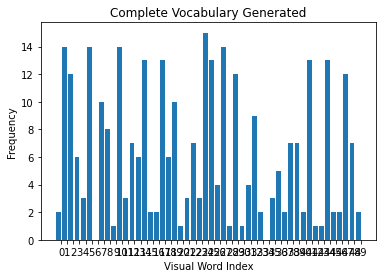

Features histogram plotted.
0.5 0.1
SVM fitted.
Training completed.
--- 20.42336082458496 seconds ---


In [21]:
train_path = "drive/My Drive/INRIA/Assignment/Objects_Dataset_Images/train"
test_path = "drive/My Drive/INRIA/Assignment/Objects_Dataset_Images/test"
no_clusters = 50
kernel = "precomputed"

start_time = time.time()
kmeans, scale, svm, im_features = trainModel(train_path, no_clusters, kernel)
print("--- %s seconds ---" % (time.time() - start_time))


### Testing and Data Prepration <a name="bovw_test"></a>

In [37]:
def testModel(path, kmeans, scale, svm, im_features, no_clusters, kernel):
    test_images = getFiles(False, path)
    print("Test images path detected.")

    count = 0
    true = []
    descriptor_list = []

    name_dict =	{
        "0": "accordion",
        "1": "dollar_bill",
        "2": "motorbike",
        "3": "Soccer_Ball",
    }

    sift = cv2.xfeatures2d.SIFT_create()

    for img_path in test_images:
        img = readImage(img_path)
        des = getDescriptors(sift, img)

        if(des is not None):
            count += 1
            descriptor_list.append(des)

            if("accordion" in img_path):
                true.append("accordion")
            elif("dollar_bill" in img_path):
                true.append("dollar_bill")
            elif("motorbike" in img_path):
                true.append("motorbike")
            #elif("Soccer_Ball" in img_path):
            else:
                true.append("Soccer_Ball")

    descriptors = vstackDescriptors(descriptor_list)

    test_features = extractFeatures(kmeans, descriptor_list, count, no_clusters)

    test_features = scale.transform(test_features)
    
    kernel_test = test_features
    if(kernel == "precomputed"):
        kernel_test = np.dot(test_features, im_features.T)
    
    predictions = [name_dict[str(int(i))] for i in svm.predict(kernel_test)]
    print("Test images classified.")
    target_names = ['accordion', 'dollar_bill', 'motorbike','Soccer_Ball']
    print(classification_report(true, predictions, target_names=target_names))
    #print(confusion_matrix(true,predictions,labels = target_names))
    
    plotConfusions(true, predictions)
    # print("Confusion matrixes plotted.")

    # findAccuracy(true, predictions)
    # print("Accuracy calculated.")
    # print("Execution done.")

In [24]:
from sklearn.metrics import classification_report

Test images path detected.
Test images classified.
              precision    recall  f1-score   support

   accordion       1.00      0.50      0.67         4
 dollar_bill       0.00      0.00      0.00         0
   motorbike       1.00      1.00      1.00         2
 Soccer_Ball       1.00      1.00      1.00         2

    accuracy                           0.75         8
   macro avg       0.75      0.62      0.67         8
weighted avg       1.00      0.75      0.83         8

Confusion matrix, without normalization
[[2 2 0 0]
 [0 0 0 0]
 [0 0 2 0]
 [0 0 0 2]]
Normalized confusion matrix
[[0.5 0.5 0.  0. ]
 [nan nan nan nan]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1. ]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in true_divide


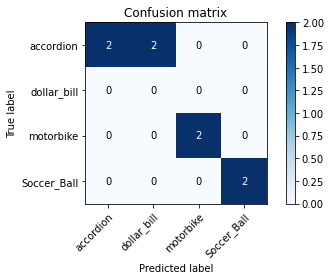

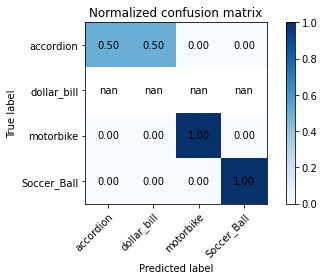

--- 1.4739341735839844 seconds ---


In [38]:
start_time = time.time()
testModel(test_path, kmeans, scale, svm, im_features, no_clusters, kernel)
print("--- %s seconds ---" % (time.time() - start_time))